<a href="https://colab.research.google.com/github/QasimKhan5x/Evaluation-Exercise/blob/main/Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
!pip install fastai --upgrade

Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.2.7)


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse
from fastai.callback import schedule

In [88]:
particles = pd.read_csv('monojet_Zp2000.0_DM_50.0_chan3.csv')
particles

,event ID,process ID,event weight,MET,METphi,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9
0,354;monojet_Zp2000.0_DM_50.0;2.44336e-05;832841;-1.22431;b,947383.0,824498.0,-0.523103,1.64421;j,258722.0,243675.0,0.328962,2.25014;j,520092.0,108590.0,-2.24730,-1.85679;j,383024.0,88405.6,2.145160,-1.95635;j,39507.6,35365.1,0.470460,-1.16445;j,225430.0,26878.2,-2.81608,-2.25938;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,354;monojet_Zp2000.0_DM_50.0;2.44336e-05;732115;1.17245;j,1070000.0,751597.0,0.858186,-1.84217;j,457647.0,110079.0,2.102870,2.17501;j,49649.1,30875.2,-1.03189,-1.7992;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,354;monojet_Zp2000.0_DM_50.0;2.44336e-05;1.05628e+06;-3.06744;j,676000.0,640429.0,0.330450,0.704554;j,1240000.0,602104.0,1.343240,-0.550856;j,193865.0,44825.7,-2.14231,-0.965933;j,28217.2,24926.6,-0.454264,0.516676;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,354;monojet_Zp2000.0_DM_50.0;2.44336e-05;631781;1.64181;j,936707.0,616229.0,0.973383,-1.56592;j,75998.0,52304.3,0.905489,-0.806736;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,354;monojet_Zp2000.0_DM_50.0;2.44336e-05;457316;-1.87536;j,640313.0,589524.0,0.390749,1.23734;j,332790.0,126272.0,1.619980,-1.85524;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6394,354;monojet_Zp2000.0_DM_50.0;2.44336e-05;914355;1.52903;j,1120000.0,1010000.0,0.453265,-1.77278;b,246762.0,95229.6,1.605110,-0.520258;j,402070.0,77864.5,2.32445,0.92948;j,74709.2,69979.3,0.359168,0.94458;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6395,354;monojet_Zp2000.0_DM_50.0;2.44336e-05;782256;-1.20751;j,1920000.0,874869.0,1.418550,1.83927;j,156224.0,152161.0,-0.222571,-1.83395;j,102296.0,64861.3,1.02478,0.412515;j,421972.0,37149.5,-3.120860,2.50949;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6396,354;monojet_Zp2000.0_DM_50.0;2.44336e-05;645619;-2.48399;j,787964.0,263158.0,1.759810,0.456786;j,408087.0,258903.0,-1.026900,1.53073;j,1430000.0,204716.0,-2.63018,-0.253528;j,75924.4,63520.6,-0.586197,0.84639;j,54710.9,47683.2,0.527799,-1.58165;j,173678.0,45568.1,-2.01196,1.10735;j,170938.0,28409.1,-2.47968,2.38334;j,43035.2,26973.3,-1.02803,0.105967;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6397,354;monojet_Zp2000.0_DM_50.0;2.44336e-05;632390;-0.975687;j,731849.0,722541.0,-0.134499,2.56393;j,268828.0,259144.0,0.153813,0.578428;j,153340.0,43931.5,1.92014,-0.237382;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Interpretation of the Dataset

From this dataset, I need to utilize 4D data given by E, pt, eta, and phi. Each event contains a variable number of objects. 

The original .csv file was not annotated with column names. So, I used Microsoft Excel to add column names locally up till the 4-momentum of obj9. 

Each event contains a variable number of objects. So, the initial objective is to extract all objects corresponding to jet particles i.e. the obj${_i}$ string ends with j. 

In [89]:
# meta columns that we don't need
meta = ['event ID',	'process ID', 'event weight', 'MET', 'METphi']
particles = particles.drop(meta, axis=1)
particles.shape

(6399, 45)

Initial inspection of the data shwos that it contains a lot of NaN values.

Let's take a closer look.

In [90]:
particles[particles['obj1'].isnull()]

,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There is no data to be found whenver obj1 is NaN. So, we can drop all instances when obj1 is NaN.

In [91]:
particles = particles.dropna(subset=['obj1'])
particles = particles.reset_index(drop=True)
particles.head()

,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9
0,258722.0,243675.0,0.328962,2.25014;j,520092.0,108590.0,-2.24730,-1.85679;j,383024.0,88405.6,2.145160,-1.95635;j,39507.6,35365.1,0.47046,-1.16445;j,225430.0,26878.2,-2.81608,-2.25938;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,457647.0,110079.0,2.102870,2.17501;j,49649.1,30875.2,-1.03189,-1.7992;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1240000.0,602104.0,1.343240,-0.550856;j,193865.0,44825.7,-2.14231,-0.965933;j,28217.2,24926.6,-0.454264,0.516676;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75998.0,52304.3,0.905489,-0.806736;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,332790.0,126272.0,1.619980,-1.85524;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Check which objects correspond to jets
particles.apply(is_jet).sum().to_frame().transpose()

,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9
0,0,0,0,4771,0,0,0,3121,0,0,0,1641,0,0,0,671,0,0,0,248,0,0,0,73,0,0,0,19,0,0,0,5,0,0,0,1,0,0,0,1,0,0,0,0,0


From the above we see that a total of $671 + 1$ jets are found in obj4 and obj8.

Now, we need to separate each object into a separate instance.

The new dataframe will have 5 columns corresponding to obj, E, pt, eta, phi. Each instance of events will now occur 9 times (obj1 - obj9) for each object.

In [93]:
particles = particles.values.reshape([-1, 5])
particles = pd.DataFrame(particles, columns=['obj', 'E', 'pt', 'eta', 'phi'])
particles.head()

,obj,E,pt,eta,phi
0,258722,243675,0.328962,2.25014;j,520092
1,108590,-2.2473,-1.85679;j,383024,88405.6
2,2.14516,-1.95635;j,39507.6,35365.1,0.47046
3,-1.16445;j,225430,26878.2,-2.81608,-2.25938;
4,NaN,NaN,NaN,NaN,NaN


In [94]:
# Remove all NaN rows
particles.dropna(how='all', inplace=True)
particles

,obj,E,pt,eta,phi
0,258722,243675,0.328962,2.25014;j,520092
1,108590,-2.2473,-1.85679;j,383024,88405.6
2,2.14516,-1.95635;j,39507.6,35365.1,0.47046
3,-1.16445;j,225430,26878.2,-2.81608,-2.25938;
9,457647,110079,2.10287,2.17501;j,49649.1
...,...,...,...,...,...
55102,170938,28409.1,-2.47968,2.38334;j,43035.2
55103,26973.3,-1.02803,0.105967;,NaN,NaN
55107,268828,259144,0.153813,0.578428;j,153340
55108,43931.5,1.92014,-0.237382;,NaN,NaN


In [95]:
# Obtain all jet objects
jets = particles[particles['obj'].astype(str).str.split(';').apply(lambda x:
                                                               False if type(x) != type([])
                                                               else x[-1] == 'j')]
jets

,obj,E,pt,eta,phi
3,-1.16445;j,225430,26878.2,-2.81608,-2.25938;
48,-0.910782;j,28297.8,26177.9,-0.371397,-2.41833;
84,0.457269;j,60190.4,25060.9,-1.51968,-0.427073;
273,-2.01513;j,138699,26861.7,2.32418,-2.84795;
444,-0.643228;j,35547.3,33920.3,-0.118132,-0.853091;j
...,...,...,...,...,...
54858,-1.28031;j,39142,31483.8,0.679338,-3.09847;
54930,1.03644;j,90539.8,59787.3,0.961666,-1.23922;j
54966,3.06679;j,42767.5,36072,-0.571172,1.37815;
55029,-2.34551;j,102738,24401.5,2.11376,-2.30433;


In [96]:
jets.isna().sum()

obj    0
E      0
pt     0
eta    0
phi    0
dtype: int64

# Normalizaion

From the literature that I have consulted, this project uses different normalization techniques such as
1. Standardization
2. Normalization to [-1, 1]
3. Custom normalization done by 
Wulff, E.. (2020). Deep Autoencoders for Compression in High Energy Physics.

The example notebook provided in Google Classroom seems to have used Custom Normalization.



In [97]:
jets = jets.drop('obj', axis=1)
jets.head()

,E,pt,eta,phi
3,225430,26878.2,-2.81608,-2.25938;
48,28297.8,26177.9,-0.371397,-2.41833;
84,60190.4,25060.9,-1.51968,-0.427073;
273,138699,26861.7,2.32418,-2.84795;
444,35547.3,33920.3,-0.118132,-0.853091;j


In [98]:
jets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 672 entries, 3 to 55101
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       672 non-null    object
 1   pt      672 non-null    object
 2   eta     672 non-null    object
 3   phi     672 non-null    object
dtypes: object(4)
memory usage: 26.2+ KB


In [99]:
jets['phi'] = jets['phi'].astype(str).str.split(';').apply(lambda x:
                                                    x if type(x) != type(x)
                                                    else x[0])
jets

,E,pt,eta,phi
3,225430,26878.2,-2.81608,-2.25938
48,28297.8,26177.9,-0.371397,-2.41833
84,60190.4,25060.9,-1.51968,-0.427073
273,138699,26861.7,2.32418,-2.84795
444,35547.3,33920.3,-0.118132,-0.853091
...,...,...,...,...
54858,39142,31483.8,0.679338,-3.09847
54930,90539.8,59787.3,0.961666,-1.23922
54966,42767.5,36072,-0.571172,1.37815
55029,102738,24401.5,2.11376,-2.30433


In [100]:
jets = jets.apply(pd.to_numeric)
jets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 672 entries, 3 to 55101
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   E       672 non-null    float64
 1   pt      672 non-null    float64
 2   eta     672 non-null    float64
 3   phi     672 non-null    float64
dtypes: float64(4)
memory usage: 26.2 KB


#### Standardization

In [101]:
jets_standard = (jets - jets.mean()) / jets.std()
jets_standard.describe()

,E,pt,eta,phi
count,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02
mean,-4.722785e-16,-1.424125e-15,-3.865955e-17,-6.178920e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.484231e-01,-1.091103e+00,-2.242398e+00,-1.728127e+00
25%,-5.463608e-01,-7.350038e-01,-7.636947e-01,-8.541883e-01
50%,-3.775672e-01,-2.773355e-01,3.572178e-02,6.767285e-03
75%,1.088860e-01,3.885952e-01,7.698767e-01,8.669688e-01
max,7.209272e+00,6.135668e+00,2.184495e+00,1.732774e+00


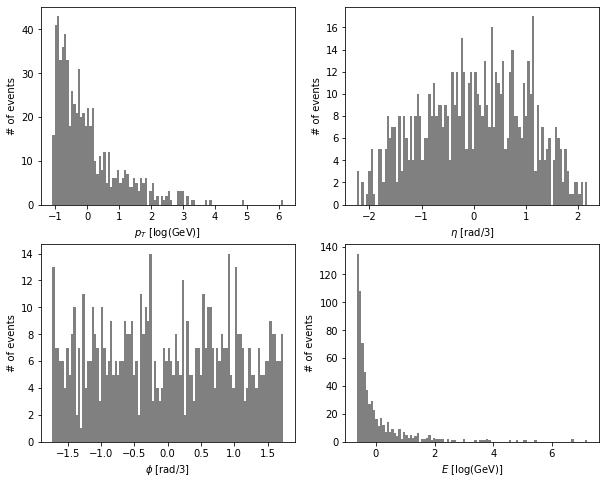

In [102]:
def plot_hist(df):

    unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
    variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

    plt.figure(figsize=(10, 8))
    branches=["pt","eta","phi","E"]
    n_bins = 100
    for kk in range(4):
        plt.subplot(220 + kk + 1)
        n_hist_data, bin_edges, _ = plt.hist(df[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
        plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
        plt.ylabel('# of events')
plot_hist(jets_standard)

#### Formula for Normalization to [-1, 1]

$x^` = 2 \frac{x - min(x)}{max(x) - min(x)} - 1$*italicized text*

In [103]:
jets11 = 2 * ((jets - jets.min()) / (jets.max() - jets.min())) - 1
jets11.describe()

,E,pt,eta,phi
count,672.000000,672.000000,672.000000,672.000000
mean,-0.834958,-0.698039,0.013080,-0.001343
std,0.254528,0.276749,0.451784,0.577884
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.974022,-0.901450,-0.331945,-0.494965
50%,-0.931060,-0.774791,0.029218,0.002568
75%,-0.807244,-0.590495,0.360898,0.499665
max,1.000000,1.000000,1.000000,1.000000


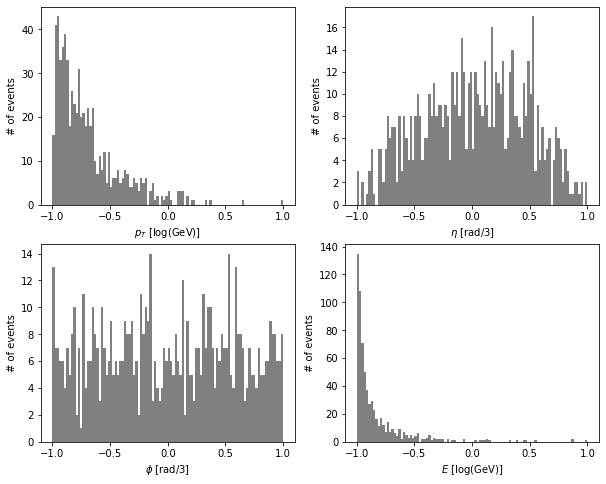

In [104]:
plot_hist(jets11)

#### Formula for Custom Normalization

pt $\longrightarrow \log _{10}pt$

E $ \longrightarrow \log _{10}E$

eta $\longrightarrow eta / 3 $

phi $\longrightarrow phi / 3$

In [105]:
jets_custom = jets.copy()
jets_custom['pt'] = np.log10(jets_custom['pt'])
jets_custom['E'] = np.log10(jets_custom['E'])
jets_custom['eta'] = jets_custom['eta'] / 3
jets_custom['phi'] = jets_custom['phi'] / 3
jets_custom.describe()

,E,pt,eta,phi
count,672.000000,672.000000,672.000000,672.000000
mean,5.028909,4.530774,0.013789,0.000750
std,0.417525,0.129726,0.677599,0.603841
min,4.393547,4.347878,-1.505657,-1.042763
25%,4.693423,4.425447,-0.503689,-0.515043
50%,4.954617,4.508311,0.037994,0.004837
75%,5.316820,4.606175,0.535457,0.524262
max,6.283301,5.044112,1.494000,1.047070


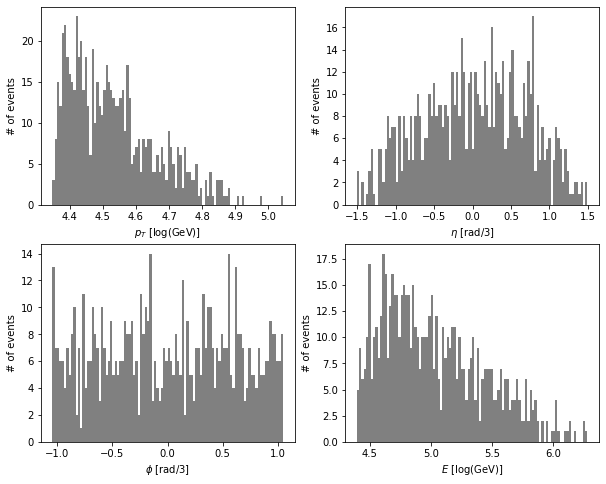

In [106]:
plot_hist(jets_custom)

The custom normalization achieved the best results due to minimal skewness. The other two achieved similar results.

Going forward, it's better to use custom normalization.

# Compression

In [107]:
from sklearn.model_selection import train_test_split

In [108]:
X_train, X_valid = train_test_split(jets_custom, test_size=0.2)

In [109]:
# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(X_train.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(X_valid.values, dtype=torch.float), torch.tensor(X_valid.values, dtype=torch.float))

In [110]:
len(train_ds)

537

In [111]:
bs = 16

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

In [112]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [113]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

Learning rate with the minimum loss: 0.017378008365631102
Learning rate with the steepest gradient: 0.0020892962347716093


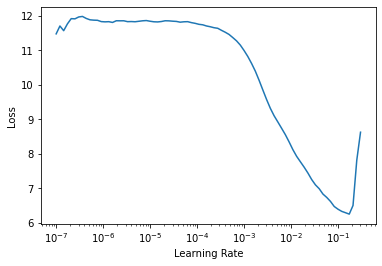

In [114]:
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [116]:
?learn.fit_one_cycle

In [ ]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')
# Training took 26.422125933000643 seconds

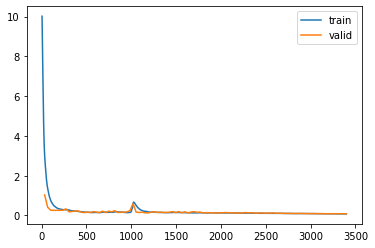

In [118]:
recorder.plot_loss()

In [119]:
learn.validate()

(#1) [0.08628098666667938]

In [120]:
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [121]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    #df['E'] = 10**df['E']
    df['E'] = 10**df['E']
    df['pt'] = 10**(df['pt'])
    return df

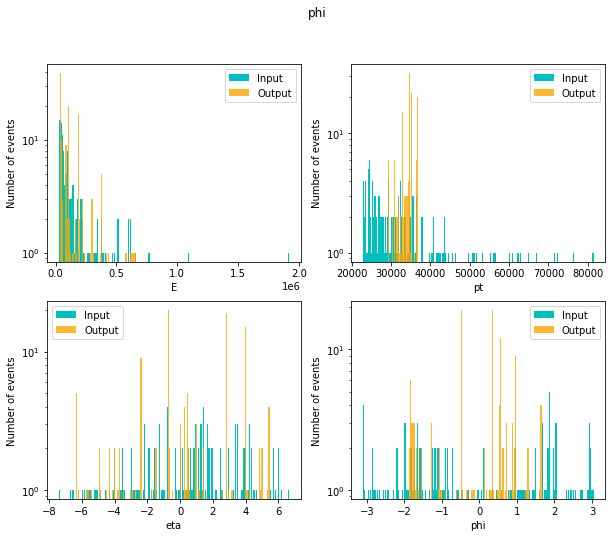

In [130]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = False # Option to save figure

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(X_valid[idxs[0]:idxs[1]].values, dtype=torch.float)
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=X_valid.columns)
pred_df = pd.DataFrame(pred, columns=X_valid.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
plt.figure(figsize=(10, 8))
for kk in np.arange(4):
    plt.subplot(220 + kk + 1)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(X_valid.columns[kk])
    plt.xlabel(X_valid.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,X_valid.columns[kk]+'.png'))
    plt.legend()